### Embryo zebrafish development data: https://pubmed.ncbi.nlm.nih.gov/37468546/

In [5]:
import sys
import os
sys.path.append(os.path.abspath("../../src/utils"))
from preprocess import *  
from plotting import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


data_dir = "../../data/embryo/raw/"
plot_dir = "../../data/embryo/plots/"
os.makedirs(plot_dir, exist_ok=True)

#### Load ATAC data and metadata

In [6]:
atac_data_path = os.path.join(data_dir, "atac_peak_matrix_complete_sparse.csv")
atac_data_df = pd.read_csv(atac_data_path)

meta_path = os.path.join(data_dir, "atac_all.metaData.txt")
atac_metadata_df = pd.read_csv(meta_path, index_col=0)


Map ATAC Cells: Assign each cell a pseudobulk, developmental stage + cell type using the authors' celltype assignment

In [7]:
atac_metadata_df = (
    atac_metadata_df
    [['celltype', 'predictedCell', 'predictedGroup']]
    .rename(columns={
        'celltype': 'atac_cell_type',
        'predictedCell': 'rna_matching_cell',
        'predictedGroup': 'rna_cell_type'
    })
    .reset_index(names="atac_cell")
)

def extract_stage(cell_id, delimiter='h', pos=0):
    return str(cell_id).split(delimiter)[pos].replace('h', '')

atac_metadata_df = atac_metadata_df.assign(
    rna_stage=lambda df: df['rna_matching_cell'].apply(extract_stage, args=('h', 0)),
    atac_stage=lambda df: df['atac_cell'].apply(extract_stage, args=('hpf', 0)),
    pseudobulk=lambda df: df['atac_stage'] + '_' + df['atac_cell_type']
)

atac_metadata_df.head()


,atac_cell,atac_cell_type,rna_matching_cell,rna_cell_type,rna_stage,atac_stage,pseudobulk
0,3hpf_1#3hpf_1_merge_BC0443_N27,blastomere,6h_3 CELL4645_N1 _,margin,6,3,3_blastomere
1,3hpf_1#3hpf_1_merge_BC0069_N07,blastomere,3h1_CELL1337_N1_3h1,blastomere,3,3,3_blastomere
2,3hpf_1#3hpf_1_merge_BC0033_N05,blastomere,3h1_CELL1337_N1_3h1,blastomere,3,3,3_blastomere
3,3hpf_1#3hpf_1_merge_BC0028_N08,blastomere,3h1_CELL1197_N1_3h1,blastomere,3,3,3_blastomere
4,3hpf_1#3hpf_1_merge_BC0264_N08,blastomere,3h1_CELL1197_N1_3h1,blastomere,3,3,3_blastomere


Aggregate accessibility signals from all cells in a pseudobulk (by pseudobulk mean)

In [8]:
atac_data_df = atac_data_df.merge(
    atac_metadata_df[['atac_cell', 'pseudobulk', 'atac_cell_type']],
    left_on='Cell', right_on='atac_cell', how='left'
)

# mean accessibility per pseudobulk
pseudobulk_matrix = (
    atac_data_df.groupby(['Peak', 'pseudobulk'])['Accessibility']
    .mean()  
    .unstack(fill_value=0)
)
# cell counts per pseudobulk
cell_counts = atac_data_df.groupby('pseudobulk')['Cell'].nunique().sort_values(ascending=False)


Boxplots: Distribution of total read count per cell in each pseudobulk - Colored by cell type
* Sorted by the most populated pseudobulks to the least
* Wider boxes might indicate either low quality cell type assignment **or** diverse chromatin accessibility behavior inside the pseudobulk (sub-categories)
* Narrow boxes indicate consistent pseudobulks --> more reliable especially on the right side of the plot (more cells)

❓ Is it a good idea to quantile normalize here?

/sasselab3/home/mourouzidou/zebrafish_development/src/utils/plotting.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


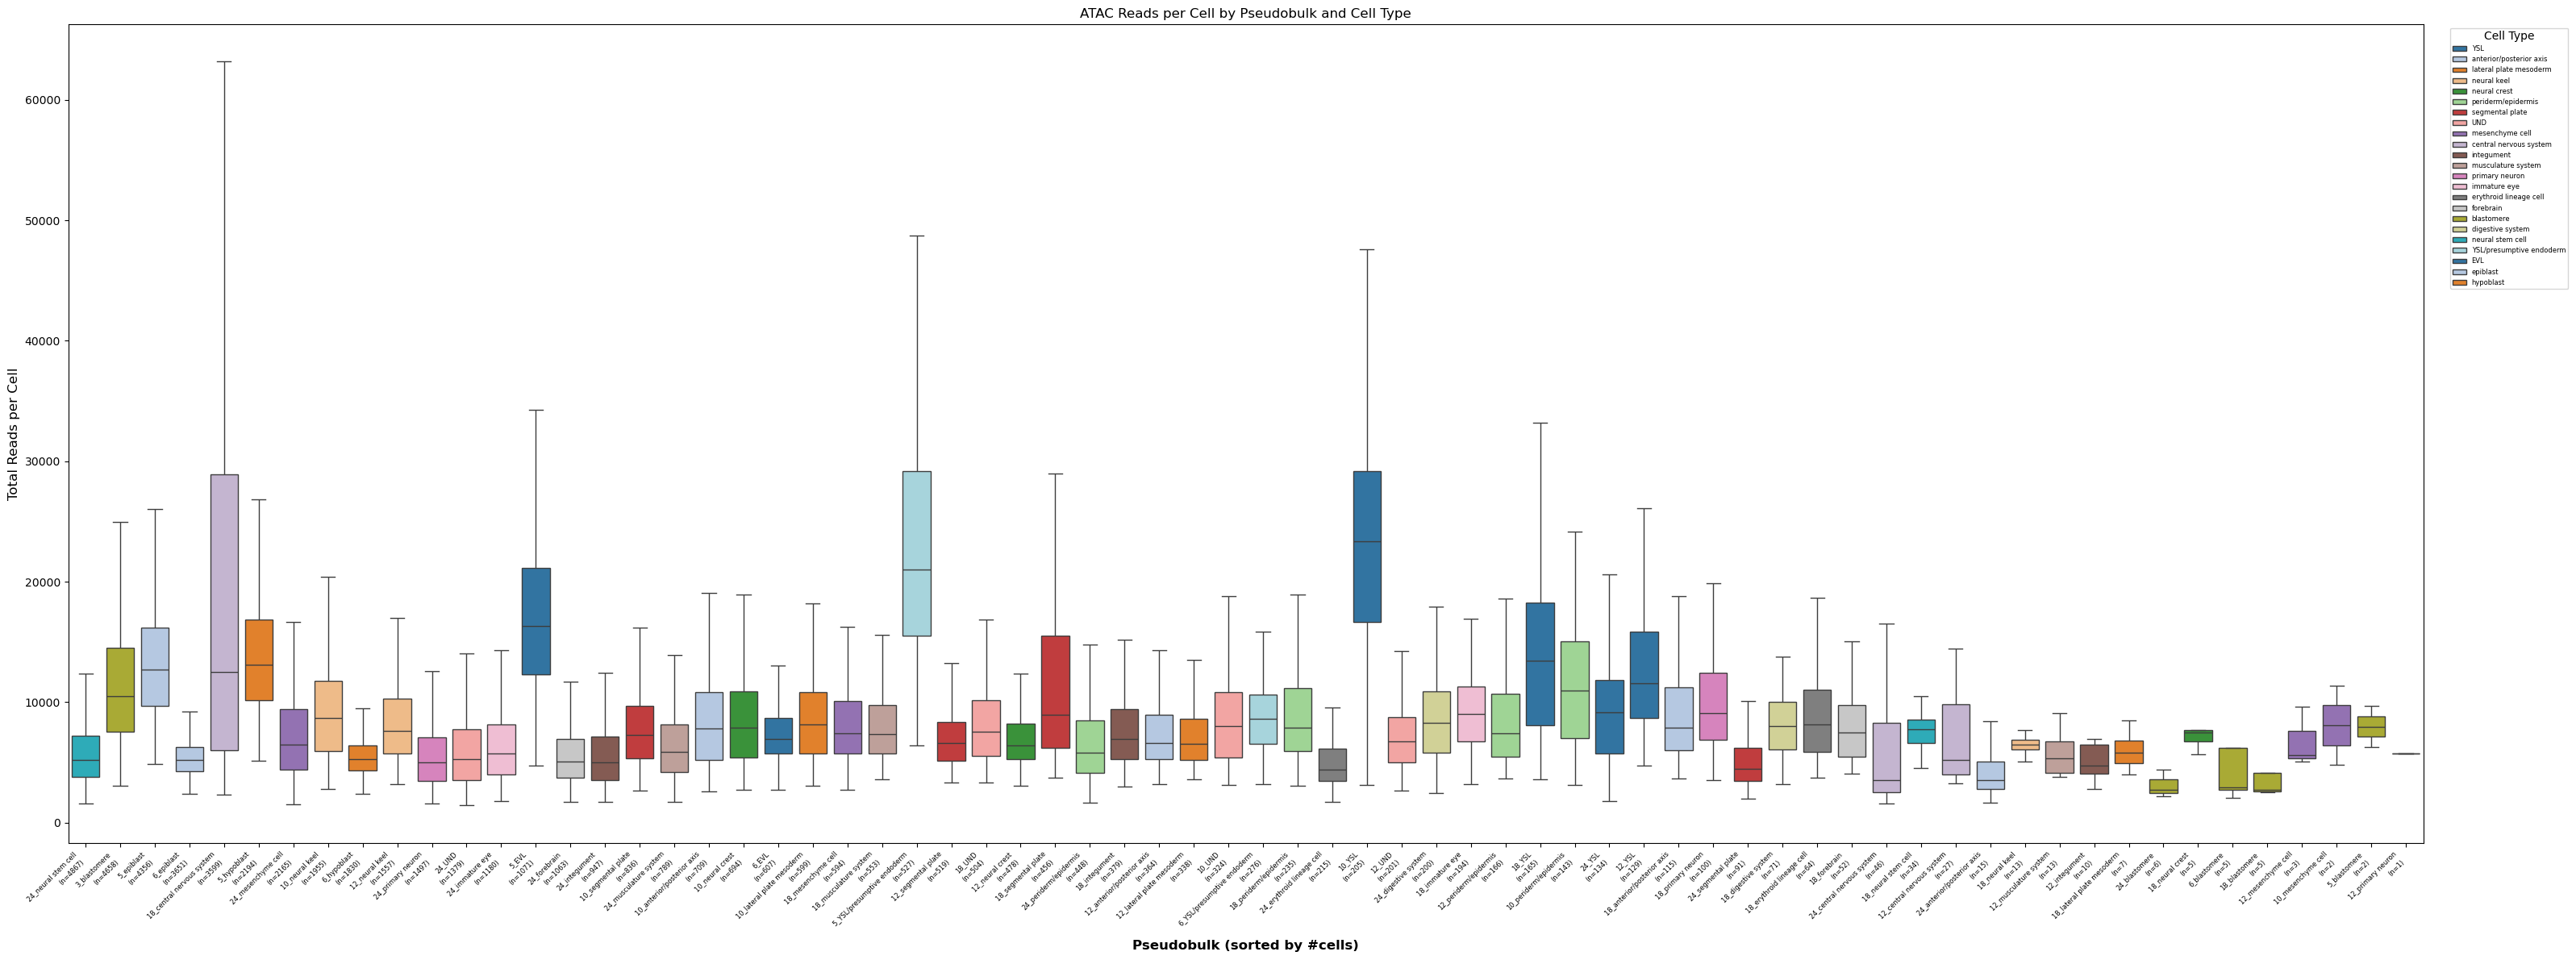

In [9]:
plot_pseudobulk_cell_read_distributions(atac_data_df, atac_metadata_df, save_path=plot_dir, show = True)

Scatterplots: Pseudobulk Cell Read Statistics vs Number of Cells

1. Median Reads per Cell: The mean depth of cells in each pseudobulk.
2. Standard Deviation (Std): The variability in total reads per cell within each pseudobulk.
3. Max-Min Range: The total reads per cell range in each pseudobulk.

Assists pseudobulking quality control.

There seems no clear trend between the pseuodbulk size and the variability of reads per cell --> suggests that the variability within pseudobulk is not due to small sample size.  
In that case we would expect the variabiility (figure 2 & 3) to decrease as the sample size increases. Thus heterogeneity could either derive from biological signal or cell missclassification.


 ❓Could this indicate that the cause of heterogeneity in some pseudobulks is biological signal? If not, is it safe to discard heterogenious pseudobulks?



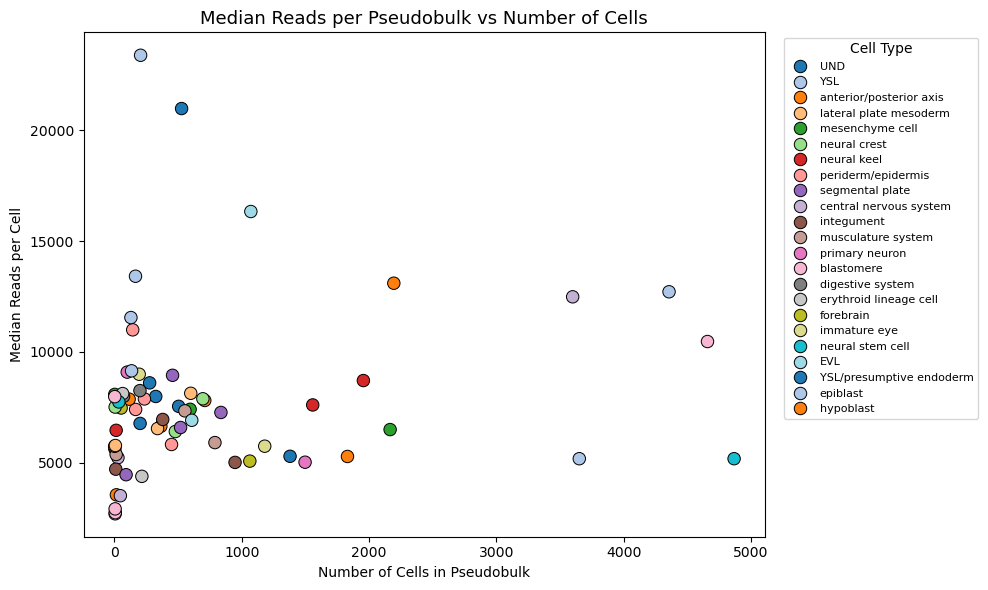

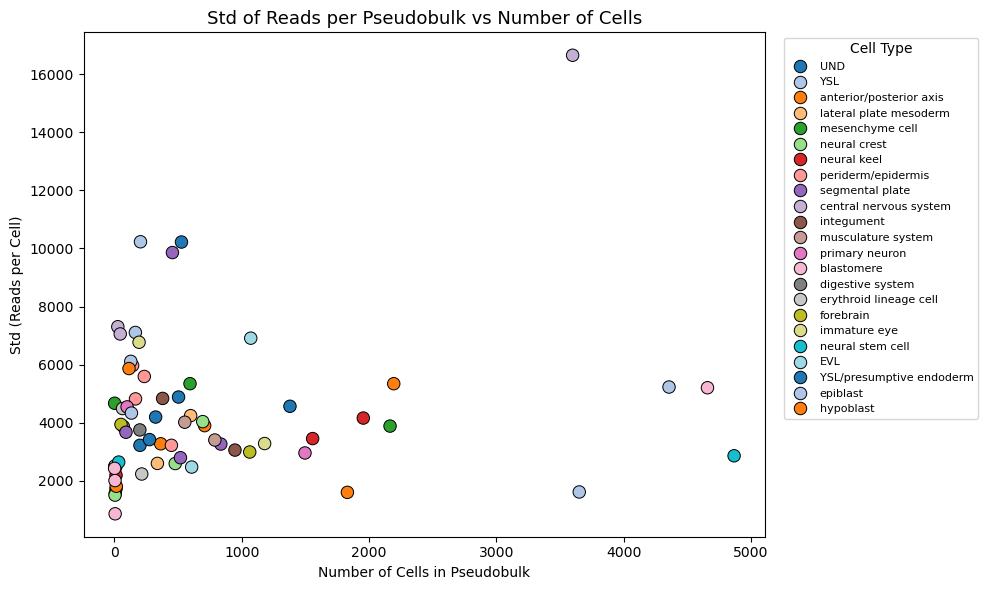

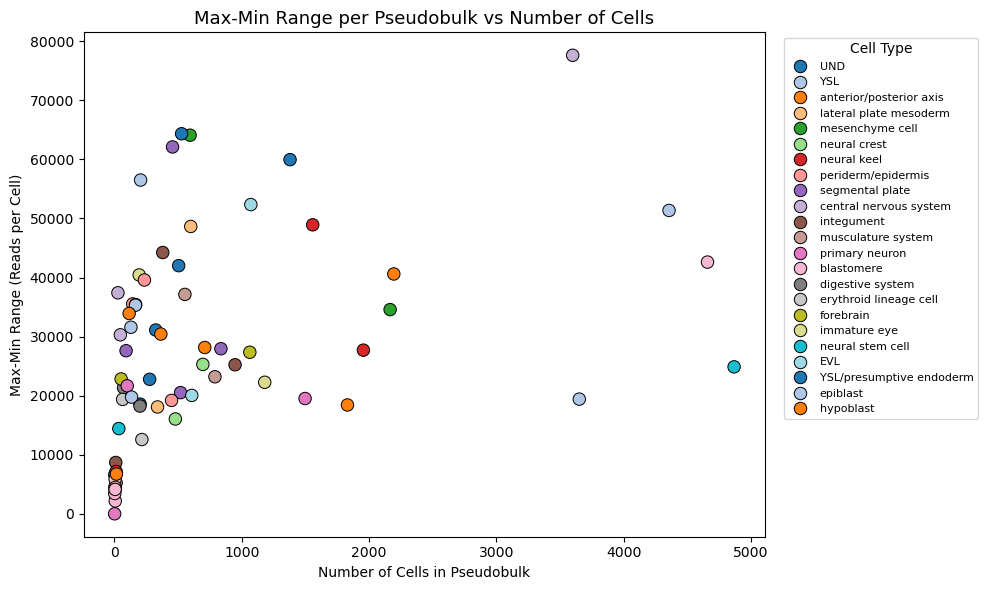

In [10]:
plot_pseudobulk_agg_stats(atac_data_df, atac_metadata_df, save_path=plot_dir, show=True)

### Plasticity check

Each boxplot shows, for a given cell type, how sequencing depth varies across developmental stages. 

* For most cell types, there is a general trend of decreasing total reads per cell as the developmental stage progresses.


Expectation:

* It is expected for earlier embryonic stages to be have a higher regulatory activity to facilitate normal cell differentiation. This could ezplain the decreasing depth trend through stages for a certain cell type.

Does this make biological sense? Can this help us filter or confirm the quality of pseudobulks?

count    50637.000000
mean      9666.958963
std       7498.662092
min       1429.000000
25%       5098.000000
50%       7498.000000
75%      11699.000000
max      79956.000000
Name: Accessibility, dtype: float64


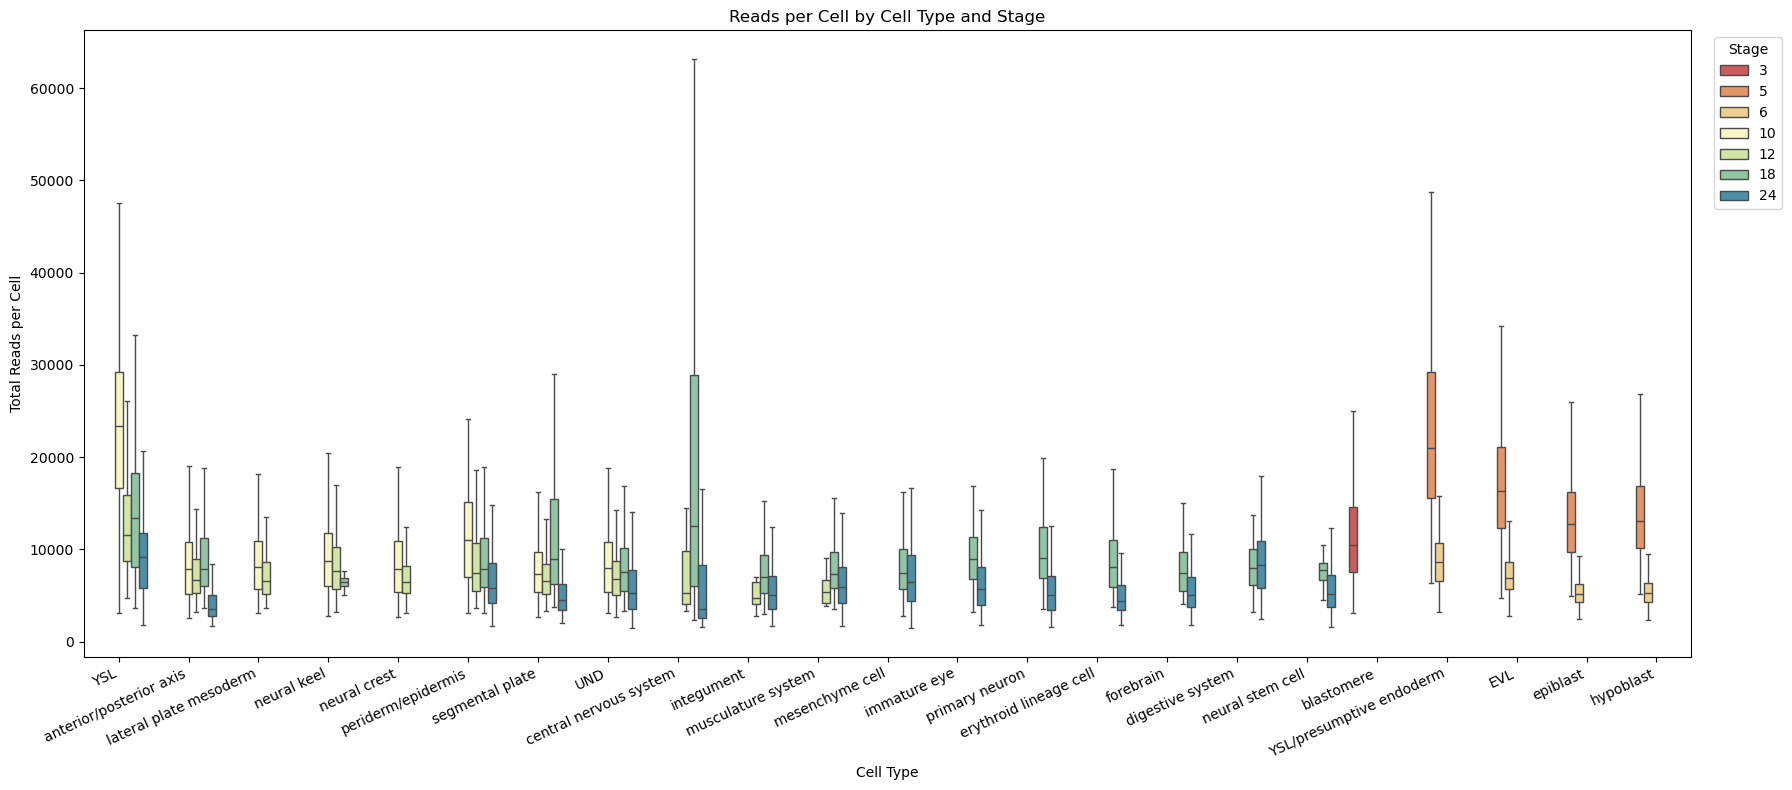

In [11]:
total_per_cell = atac_data_df.groupby('Cell')['Accessibility'].sum()
print(total_per_cell.describe())

plot_reads_per_cell_by_celltype_and_stage(
    total_per_cell,
    atac_metadata_df,
    min_cells_per_group=10,
    figsize=(18, 8),
    save_path = '../../data/embryo/plots/reads_per_cell_by_celltype_and_stage.png',
    show=True)

In [12]:

atac_data_cpm = cpm_normalize_sparse(atac_data_df)

pseudo_cpm = aggregate_atac_to_pseudobulk(atac_data_cpm, value_col='CPM')

In [13]:
# cpm NO quantile normalization
cpm_raw = pseudo_cpm.copy()  # raw

cpm_log = pseudo_cpm.copy()  # log
cpm_log = np.log1p(pseudo_cpm)

# cpm QUANTILE normalization
cpm_Nolog_Qn = quantile_normalize(cpm_raw) # raw

cpm_log_Qn = quantile_normalize(cpm_log)   # log


In [14]:
# convert cpm_Nolog_Qn and cpm_log_Qn to DataFrames
cpm_Nolog_Qn = pd.DataFrame(cpm_Nolog_Qn, index=pseudo_cpm.index, columns=pseudo_cpm.columns)
cpm_log_Qn= pd.DataFrame(cpm_log_Qn, index=pseudo_cpm.index, columns=pseudo_cpm.columns)

Boxplot showing the CPM (cell's accessibility devided by the total number of reads and multiplied by 100) aggregated (by mean) dataset
* before and after logging the pseudobulks' accessibility values
* before and after quantile normalizing

x-axis: pseudobulks sorted by cell number in them

y-axis: accessibility values

/sasselab3/home/mourouzidou/zebrafish_development/src/utils/plotting.py:247: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=6)


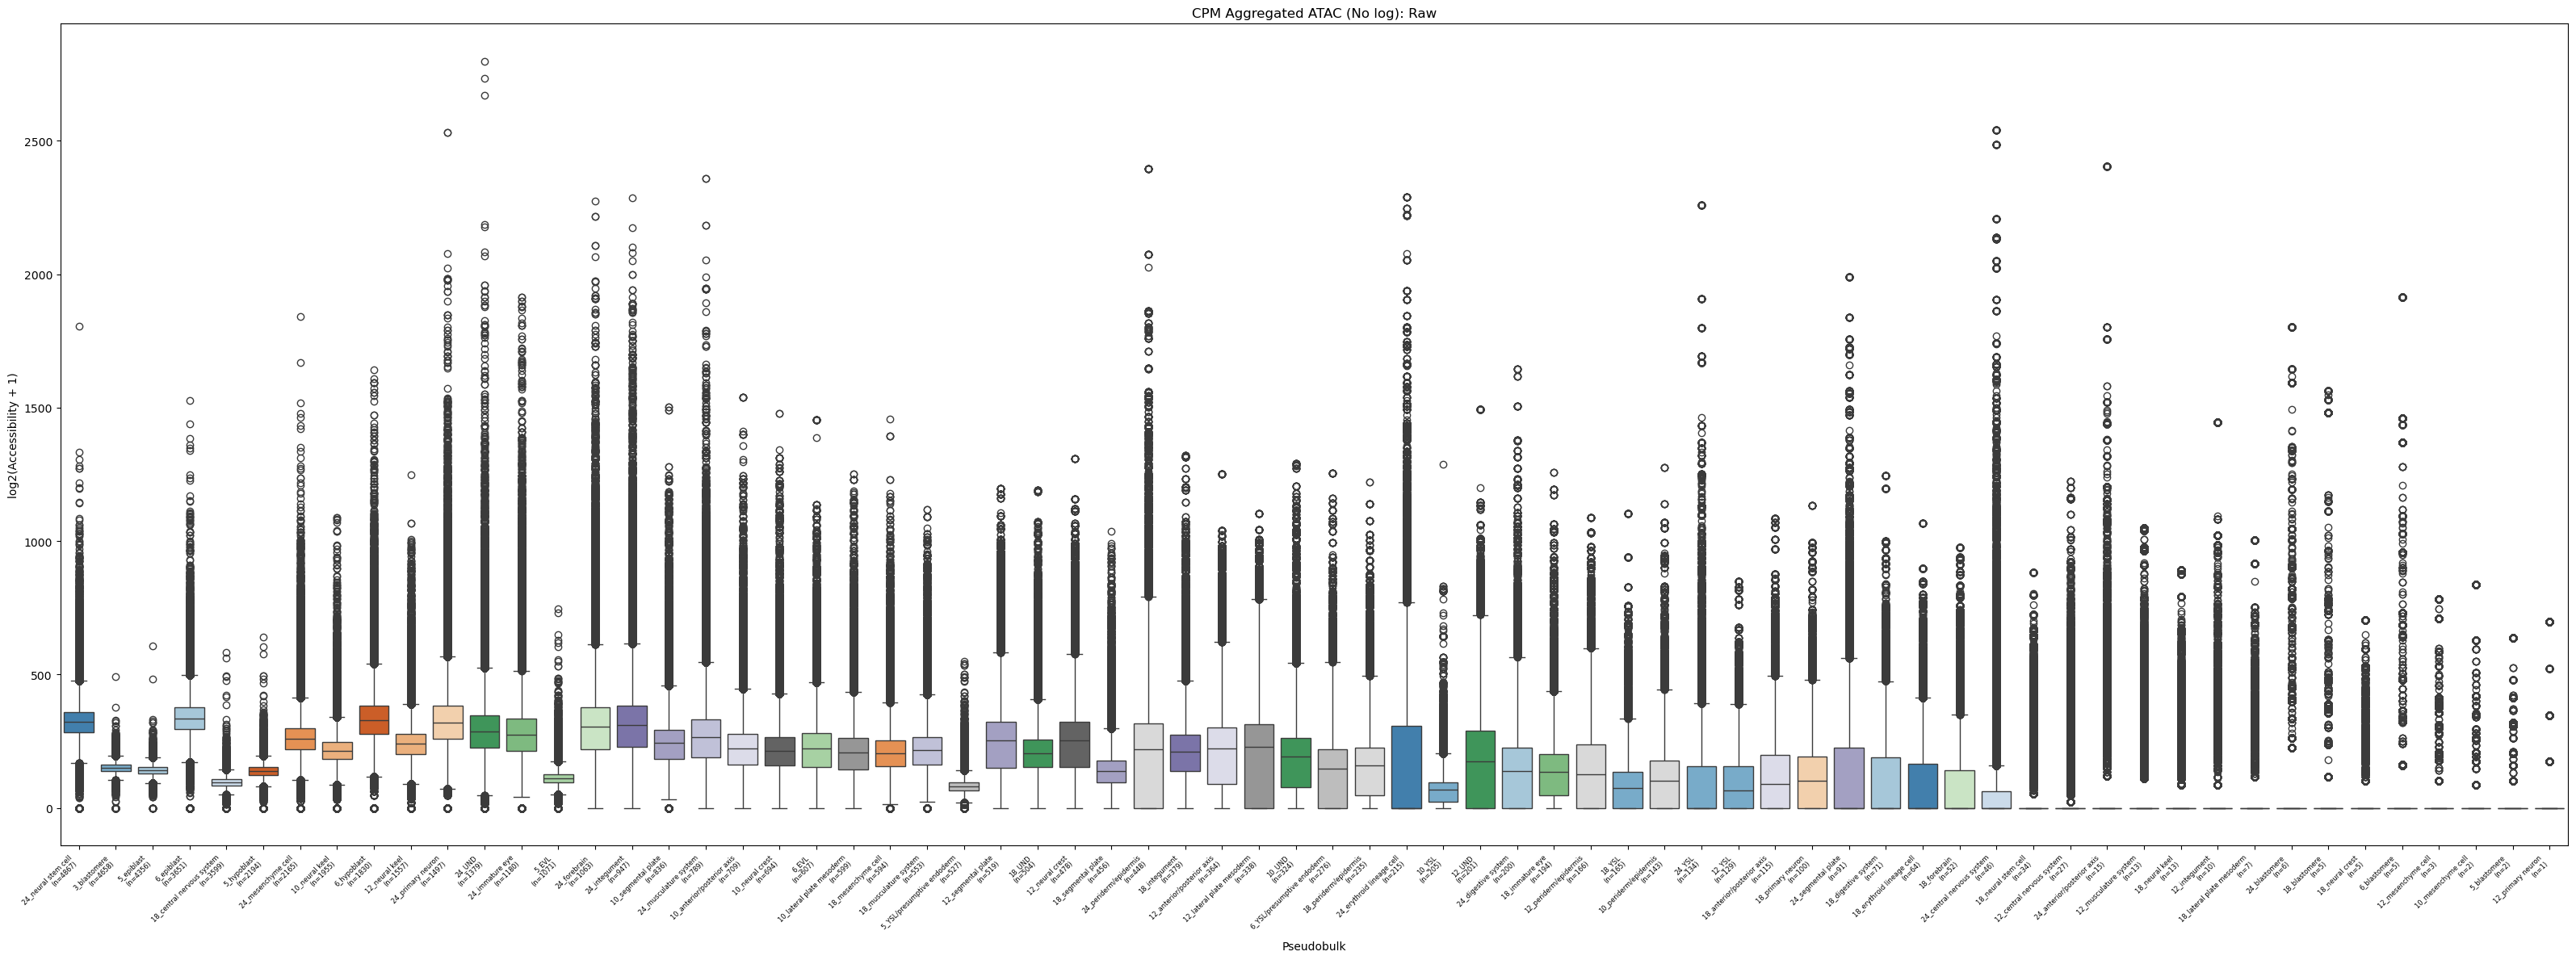

/sasselab3/home/mourouzidou/zebrafish_development/src/utils/plotting.py:247: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=6)


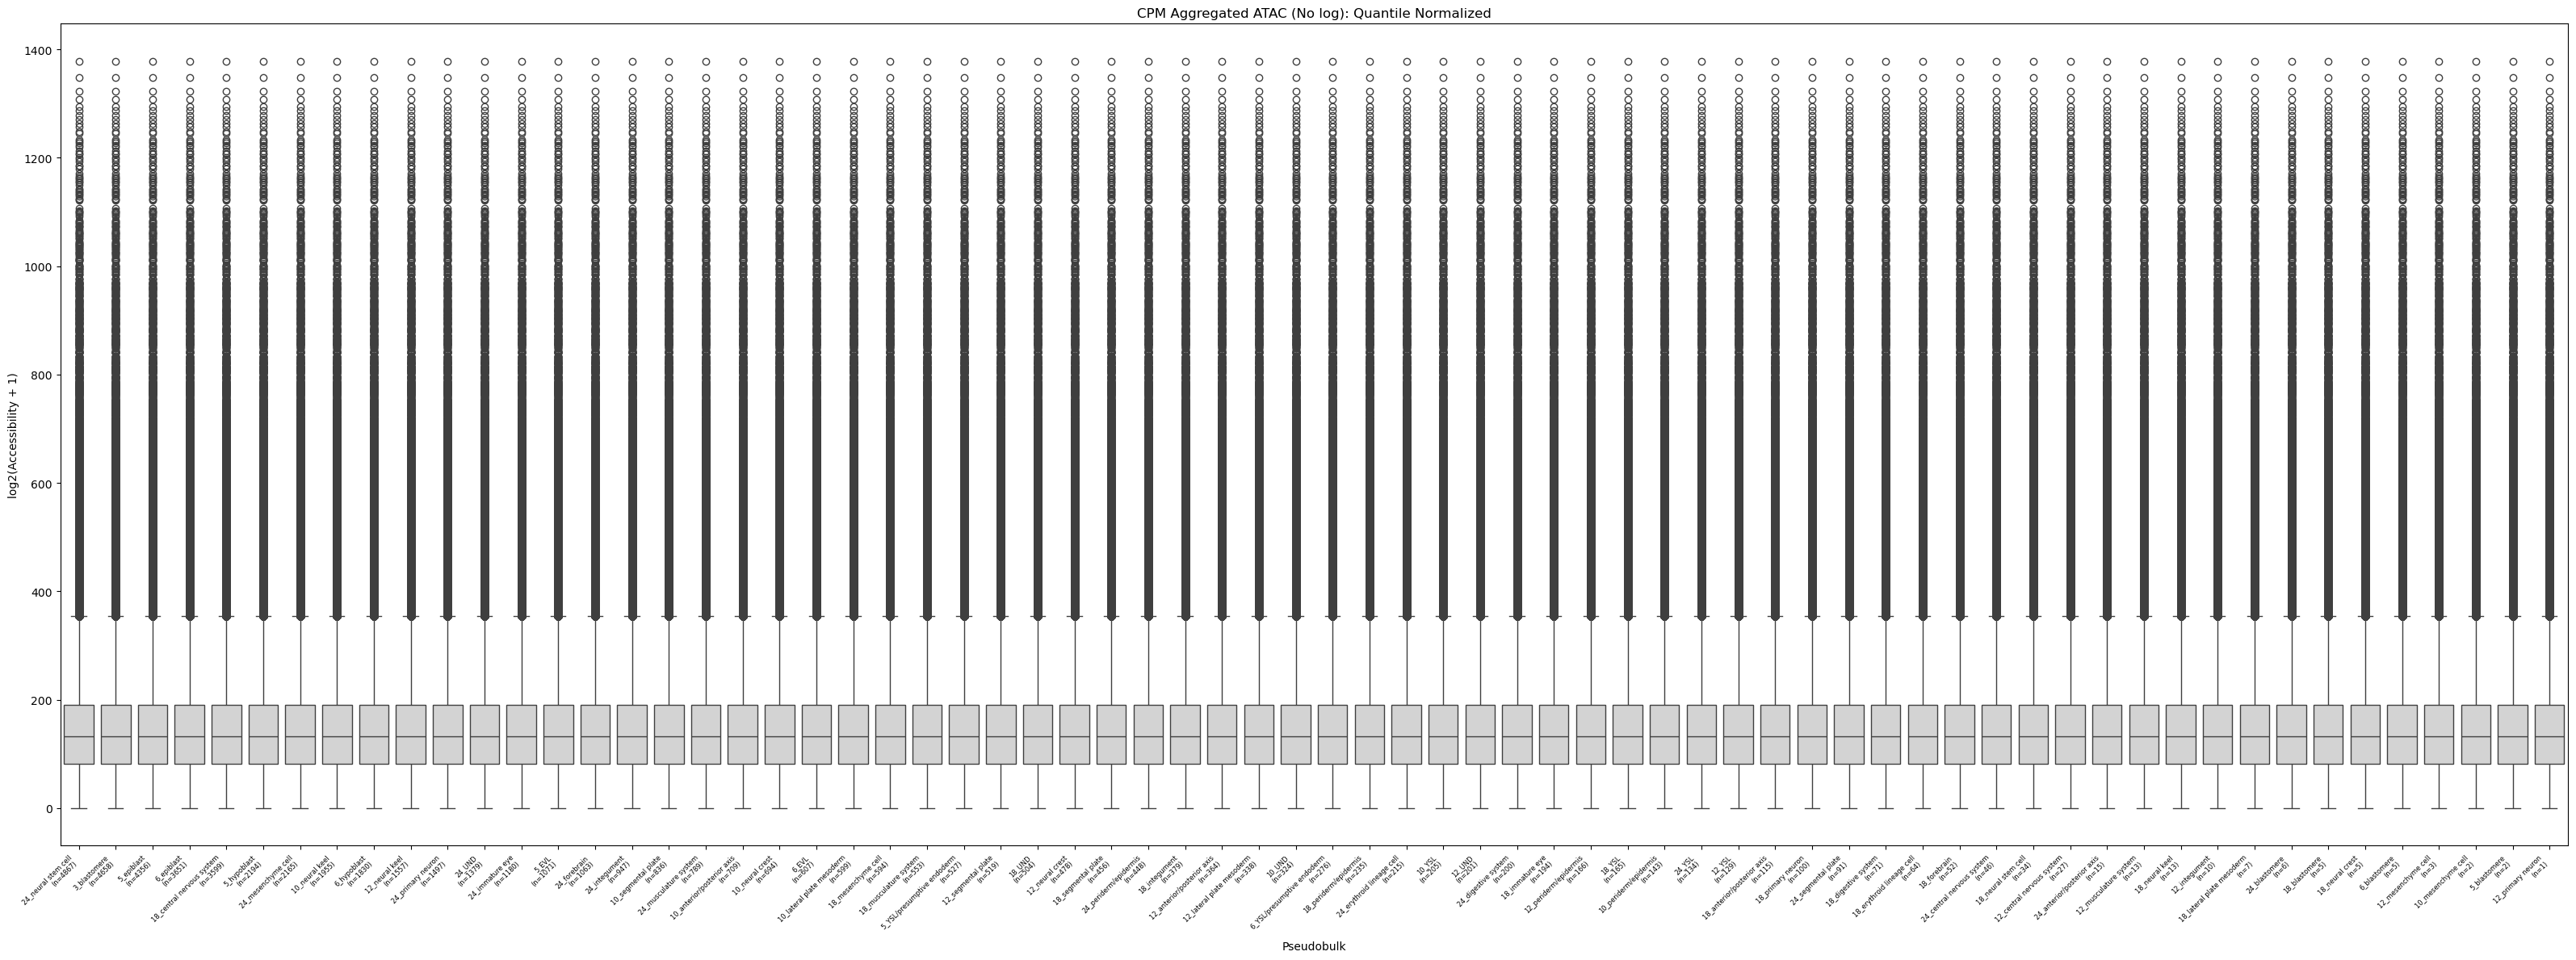

/sasselab3/home/mourouzidou/zebrafish_development/src/utils/plotting.py:247: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=6)


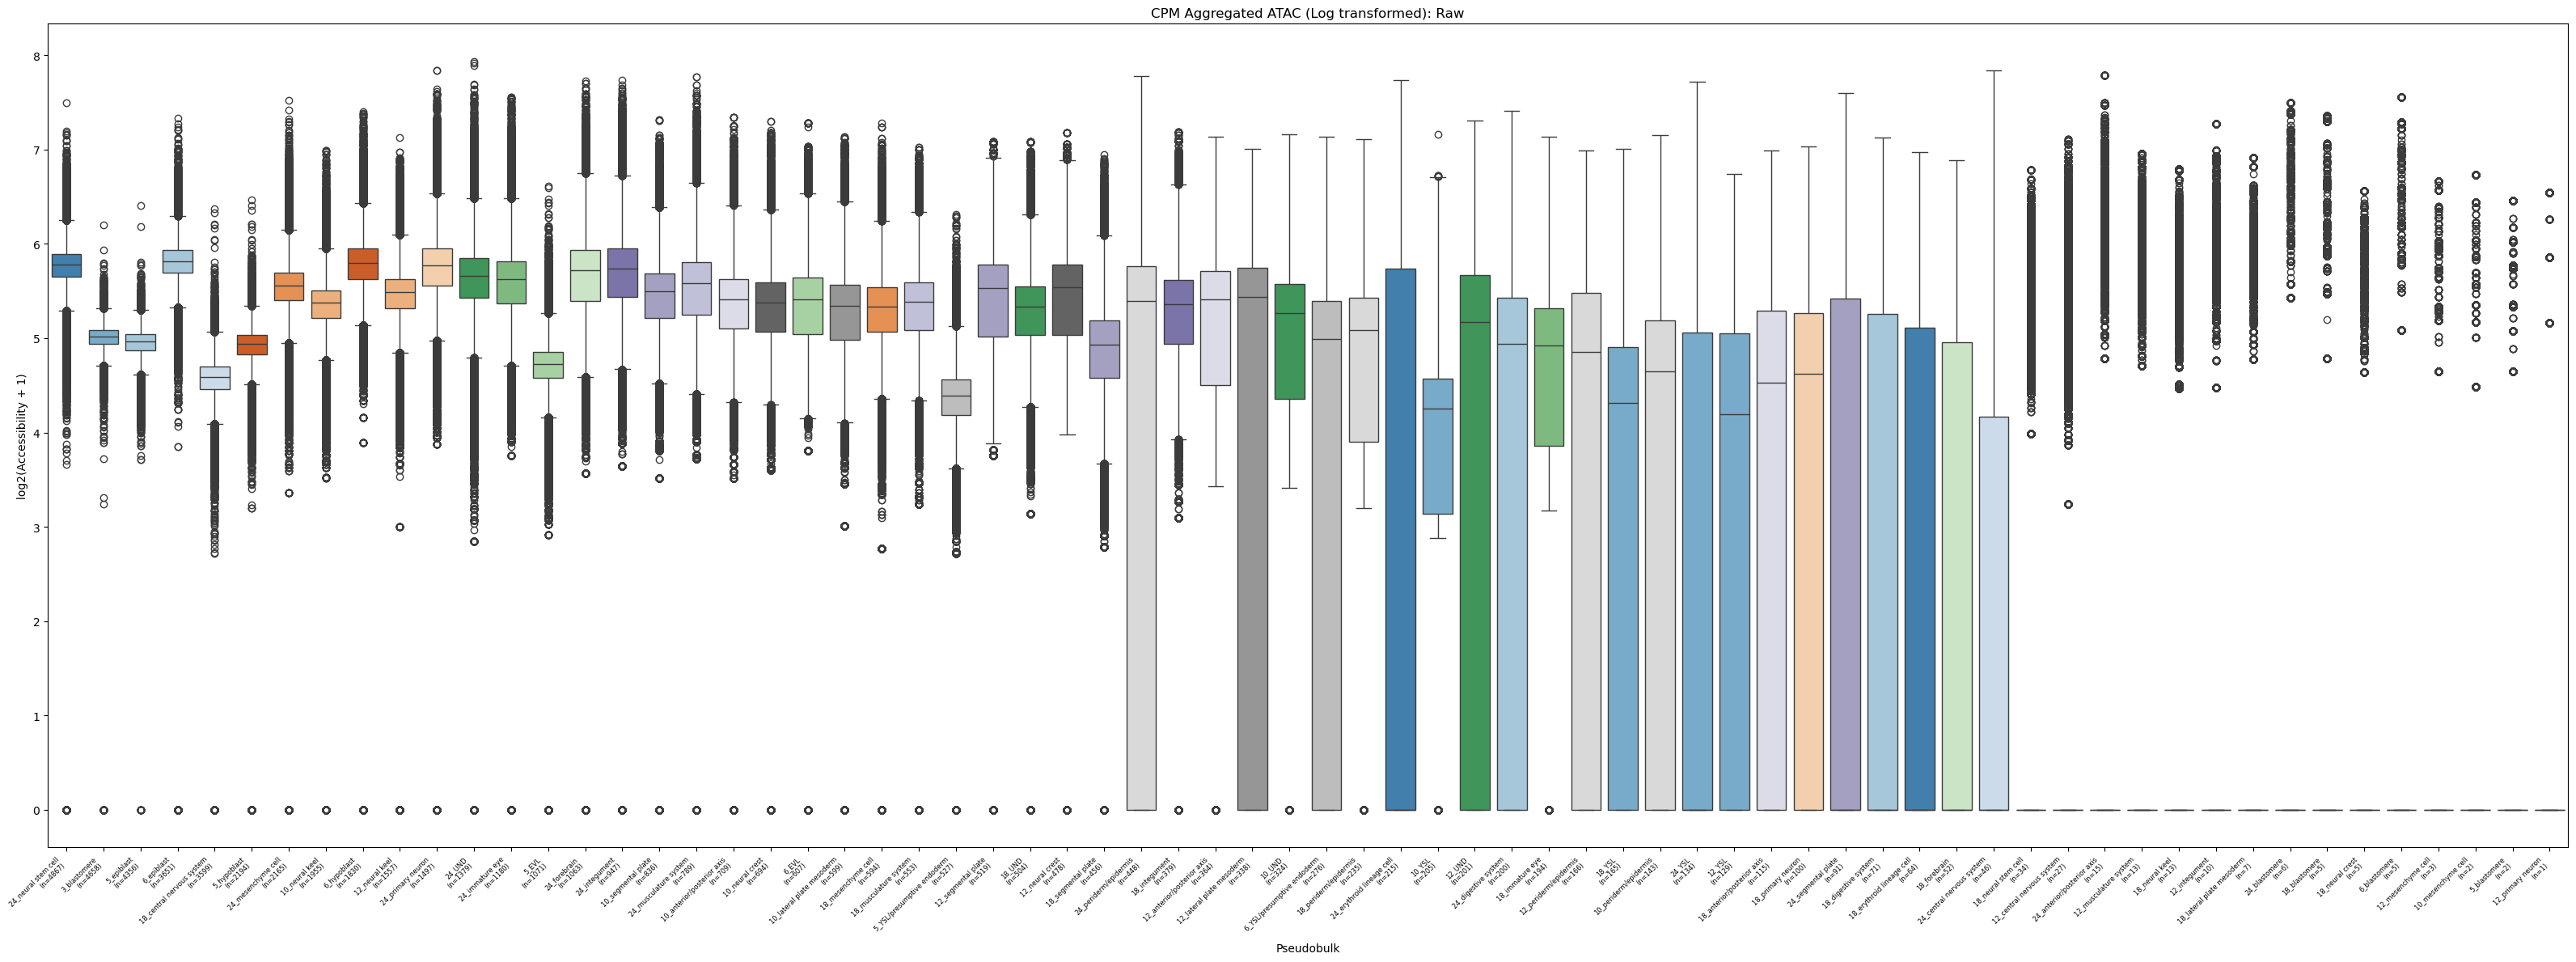

/sasselab3/home/mourouzidou/zebrafish_development/src/utils/plotting.py:247: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=6)


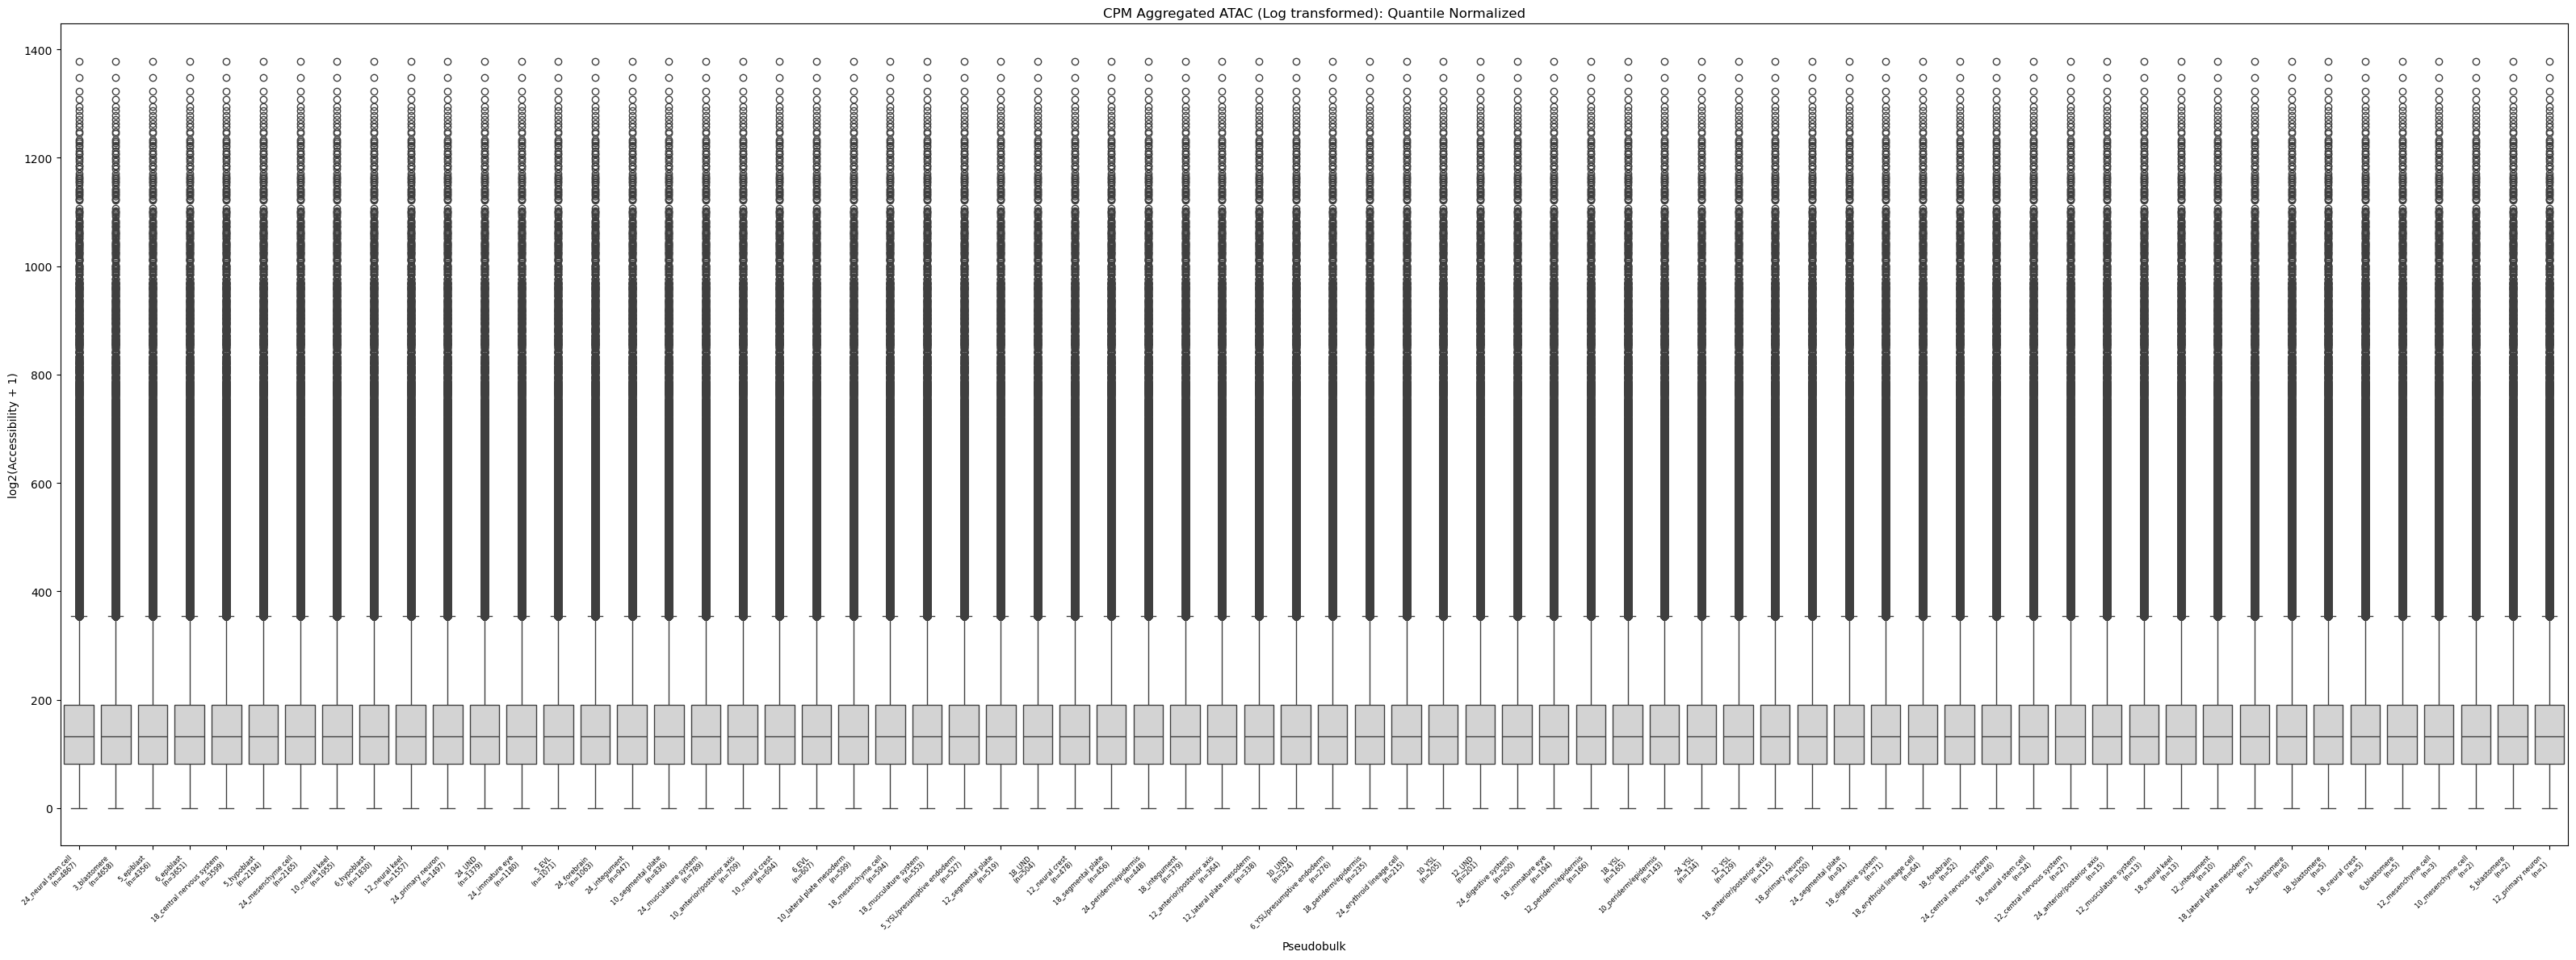

In [43]:
plot_dir = "../../data/embryo/plots"
pseudobulk_counts = atac_metadata_df['pseudobulk'].value_counts().to_dict()

plot_distributions(df_raw=cpm_raw, df_quant=cpm_Nolog_Qn, 
    title_prefix="CPM Aggregated ATAC (No log)",
    pseudobulk_counts=pseudobulk_counts,
)

plot_distributions(df_raw=cpm_log, df_quant=cpm_Nolog_Qn, 
    title_prefix="CPM Aggregated ATAC (Log transformed)",
    pseudobulk_counts=pseudobulk_counts)


In [16]:
# coordinate dataframe from atac_data_df
peak_coords = (
    atac_data_df[['Peak']]
    .drop_duplicates()
    .assign(
        chromosome=lambda df: df['Peak'].str.extract(r'(chr[\w]+)'),
        start=lambda df: df['Peak'].str.extract(r':(\d+)-')[0].astype(int),
        end=lambda df: df['Peak'].str.extract(r'-(\d+)')[0].astype(int)
    )
)
def attach_coords(matrix_df):
    return (
        matrix_df.reset_index()
        .merge(peak_coords, on='Peak', how='left')
        .dropna(subset=['chromosome', 'start', 'end'])
    )
attach_coords(cpm_Nolog_Qn)

,Peak,10_UND,10_YSL,10_anterior/posterior axis,10_lateral plate mesoderm,10_mesenchyme cell,10_neural crest,10_neural keel,10_periderm/epidermis,10_segmental plate,...,5_epiblast,5_hypoblast,6_EVL,6_YSL/presumptive endoderm,6_blastomere,6_epiblast,6_hypoblast,chromosome,start,end
0,chr10:10002124-10002624,227.962051,181.654777,103.516212,190.998689,98.369401,154.247849,132.303713,355.770787,316.733675,...,139.263580,704.243012,99.664518,124.326180,98.172019,199.830441,310.269467,chr10,10002124,10002624
1,chr10:10003707-10004207,95.616241,79.235187,208.574945,36.067774,166.684623,99.750673,157.435801,51.546468,158.357203,...,95.529046,268.721257,25.731497,69.309024,166.314839,20.385610,14.365602,chr10,10003707,10004207
2,chr10:10004747-10005247,187.574108,79.178752,140.997044,121.030503,166.684159,197.013725,227.825319,144.481713,95.656937,...,93.515776,71.585907,150.388137,95.017435,166.314168,42.245950,25.201116,chr10,10004747,10005247
3,chr10:10008047-10008547,181.011130,79.179441,181.276390,131.624200,166.683802,238.482246,161.921147,230.470500,214.497428,...,161.910790,144.346132,130.881981,162.032084,166.313594,196.567754,303.837034,chr10,10008047,10008547
4,chr10:10009662-10010162,67.077045,79.180059,133.716737,36.068044,166.683408,81.294684,30.823509,169.408303,930.136161,...,132.904348,60.921275,54.335778,44.442009,166.312775,61.469511,14.291516,chr10,10009662,10010162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370053,chr9:998557-999057,67.056870,81.259353,71.338217,60.323235,98.373136,70.286536,434.838738,51.547825,340.154245,...,257.987979,87.433539,232.323085,126.123798,98.174456,204.507955,239.324525,chr9,998557,999057
370054,chr9:9989556-9990056,128.560820,186.652011,162.931413,610.216712,98.372359,76.104272,185.506834,196.227314,97.943797,...,89.399295,163.681794,148.517759,244.499259,98.173991,20.795192,62.367338,chr9,9989556,9990056
370055,chr9:9992990-9993490,82.180553,95.299294,54.726086,97.307785,98.371800,23.745042,66.327228,107.165296,33.171622,...,43.715343,64.717616,62.489876,44.426462,98.173605,111.050409,227.013775,chr9,9992990,9993490
370056,chr9:9997607-9998107,148.517759,239.485337,79.363866,58.766134,98.371106,23.738931,134.081381,305.942082,99.917246,...,169.022614,58.628052,101.381672,323.362322,98.173015,191.288553,68.978274,chr9,9997607,9998107


In [17]:
# FASTA files directory
fasta_dir = "../../data/genome"
save_dir = "../../data/embryo/processed"

expansion_length = 2000

# apply to each version and save 
df_nolog = attach_coords(cpm_raw)
nolog_seq = extract_centered_sequences(df_nolog, fasta_dir, expansion_length, save_dir)

df_log = attach_coords(cpm_log)
log_seq = extract_centered_sequences(df_log, fasta_dir, expansion_length, save_dir)

df_nolog_qn = attach_coords(cpm_Nolog_Qn)
nolog_Qn_seq = extract_centered_sequences(df_nolog_qn, fasta_dir, expansion_length, save_dir)

df_log_qn = attach_coords(cpm_log_Qn)
log_Qn_seq = extract_centered_sequences(df_log_qn, fasta_dir, expansion_length, save_dir)


### Use [Danio_rerio.GRCz11.111.chr.gtf](https://ftp.ensembl.org/pub/release-111/gtf/danio_rerio/) file to extract a list of TSS positions.
 - consider only gene entries
 - for the + strand take the 'start' position 
 - for the - strand take the 'end' position

In [18]:
gtf_path = "../../data/genome/Danio_rerio.GRCz11.111.chr.gtf"


In [19]:
gene_info = extract_gene_info_from_gtf(gtf_path)
gene_info.head()

,chrom,start,end,tss_position,gene_name,gene_id
0,4,30402837,30403763,30402837,CR383668.1,ENSDARG00000103202
1,4,1722899,1730920,1722899,fgfr1op2,ENSDARG00000009657
2,4,40758511,40759309,40758511,AL845295.2,ENSDARG00000096472
3,4,11099041,11106856,11106856,si:dkey-21h14.12,ENSDARG00000096156
4,4,40835393,40839221,40835393,si:dkey-285e18.2,ENSDARG00000076160


Compute the total promoter depth and the total enhancer depth for each cell 
- dist > 100 => enhancer else promoter

In [21]:
dist = 100  # distance threshold for TSS annotation

ann_100 = annotate_peaks_with_genomic_info(log_seq, gene_info, distance_threshold=dist)
print(ann_100['genomic_context'].value_counts()) # intra/inter genic 
print(ann_100['region_type'].value_counts()) # promoter/enhancer


genomic_context
intragenic    240801
intergenic    129257
Name: count, dtype: int64
region_type
enhancer    358548
promoter     11510
Name: count, dtype: int64


In [30]:
summary_100 = summarize_peak_accessibility(atac_data_df, ann_100, atac_metadata_df)
print(summary_100.head())

                         Cell  total_enhancer_accessibility  \
0  10hpf_1#10hpf_1_BC0020_N02                      2.439009   
1  10hpf_1#10hpf_1_BC0021_N02                      2.139651   
2  10hpf_1#10hpf_1_BC0023_N01                      2.196931   
3  10hpf_1#10hpf_1_BC0024_N02                      2.368189   
4  10hpf_1#10hpf_1_BC0026_N01                      2.374190   

   total_promoter_accessibility  total_intergenic_accessibility  \
0                      2.497758                        2.460963   
1                      2.238818                        2.142711   
2                      2.250167                        2.190924   
3                      2.472296                        2.389806   
4                      2.522621                        2.371226   

   total_intragenic_accessibility           atac_cell_type  \
0                        2.438679                      YSL   
1                        2.153030  anterior/posterior axis   
2                        2.20768

### Split the accessibility dataset to one containing enhancer peaks and one containing promoter peaks
- plot the mean enhancer vs. the mean promoter accessibility per cell in each celltype and each pseudobulk
- Promoters are generally more accessible (as expected) and most of the cell types have a similar behavior

/tmp/ipykernel_1803020/4288730143.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=25, ha='right', fontsize=9)


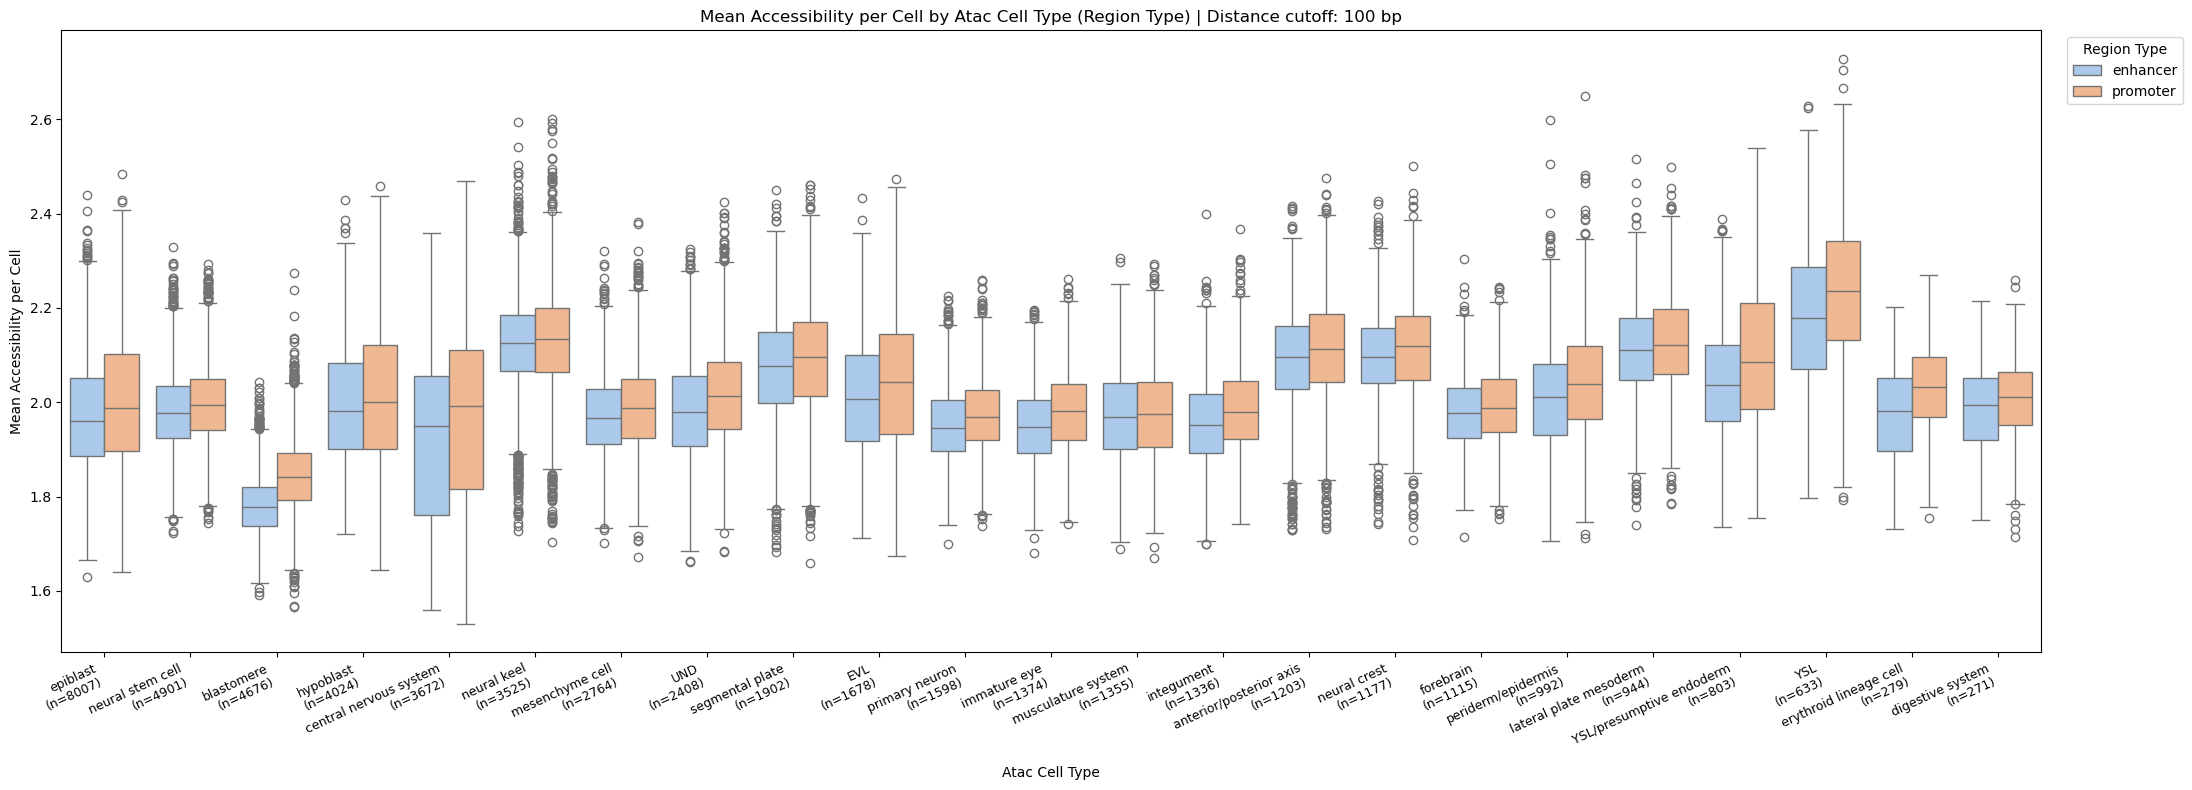

In [38]:


plot_summary_accessibility(
    summary_100, 
    gen_info="region_type",
    group_by="atac_cell_type",
    dist=100,
    show=True,
    save_path="../../data/embryo/plots/boxplot_mean_accessibility_per_celltype_regiontype_100bp.png"
)


/tmp/ipykernel_1803020/2109858836.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=25, ha='right', fontsize=9)


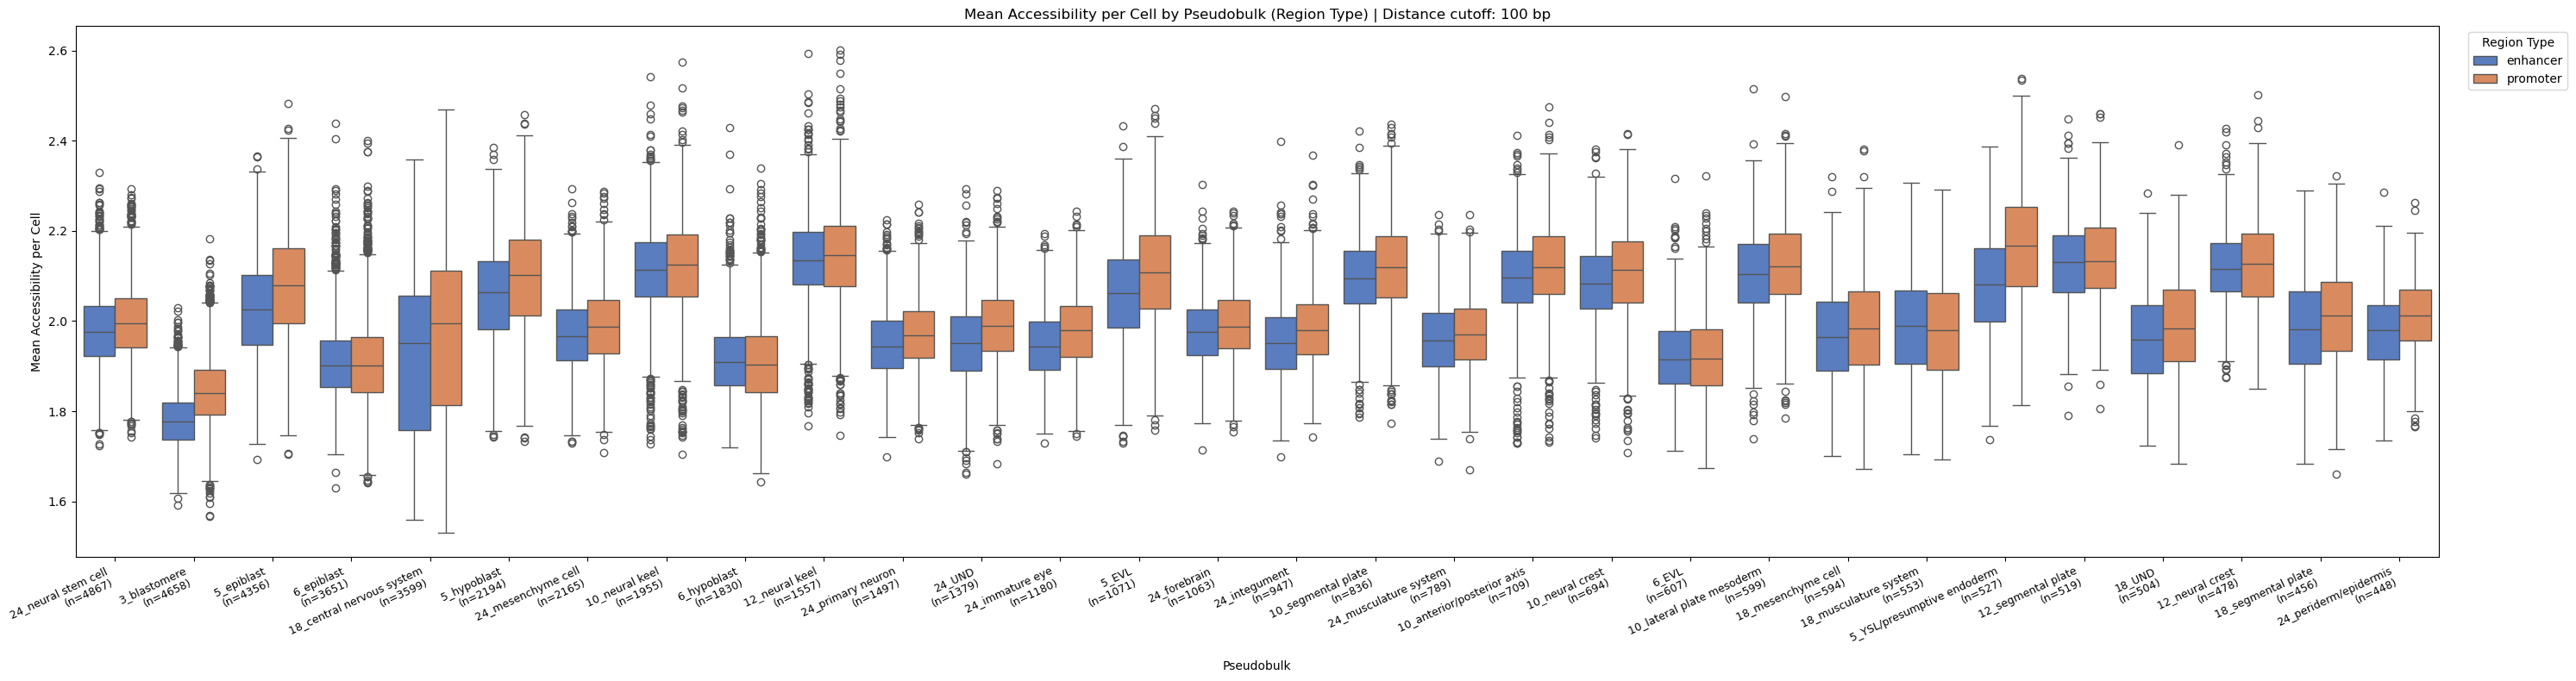

In [51]:
# Show only the top 20 pseudobulks
plot_summary_accessibility(
    summary_100,
    gen_info="region_type",
    group_by="pseudobulk",
    n_psd=30,
    dist=100,
    show=True
)


/tmp/ipykernel_1803020/4288730143.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=25, ha='right', fontsize=9)


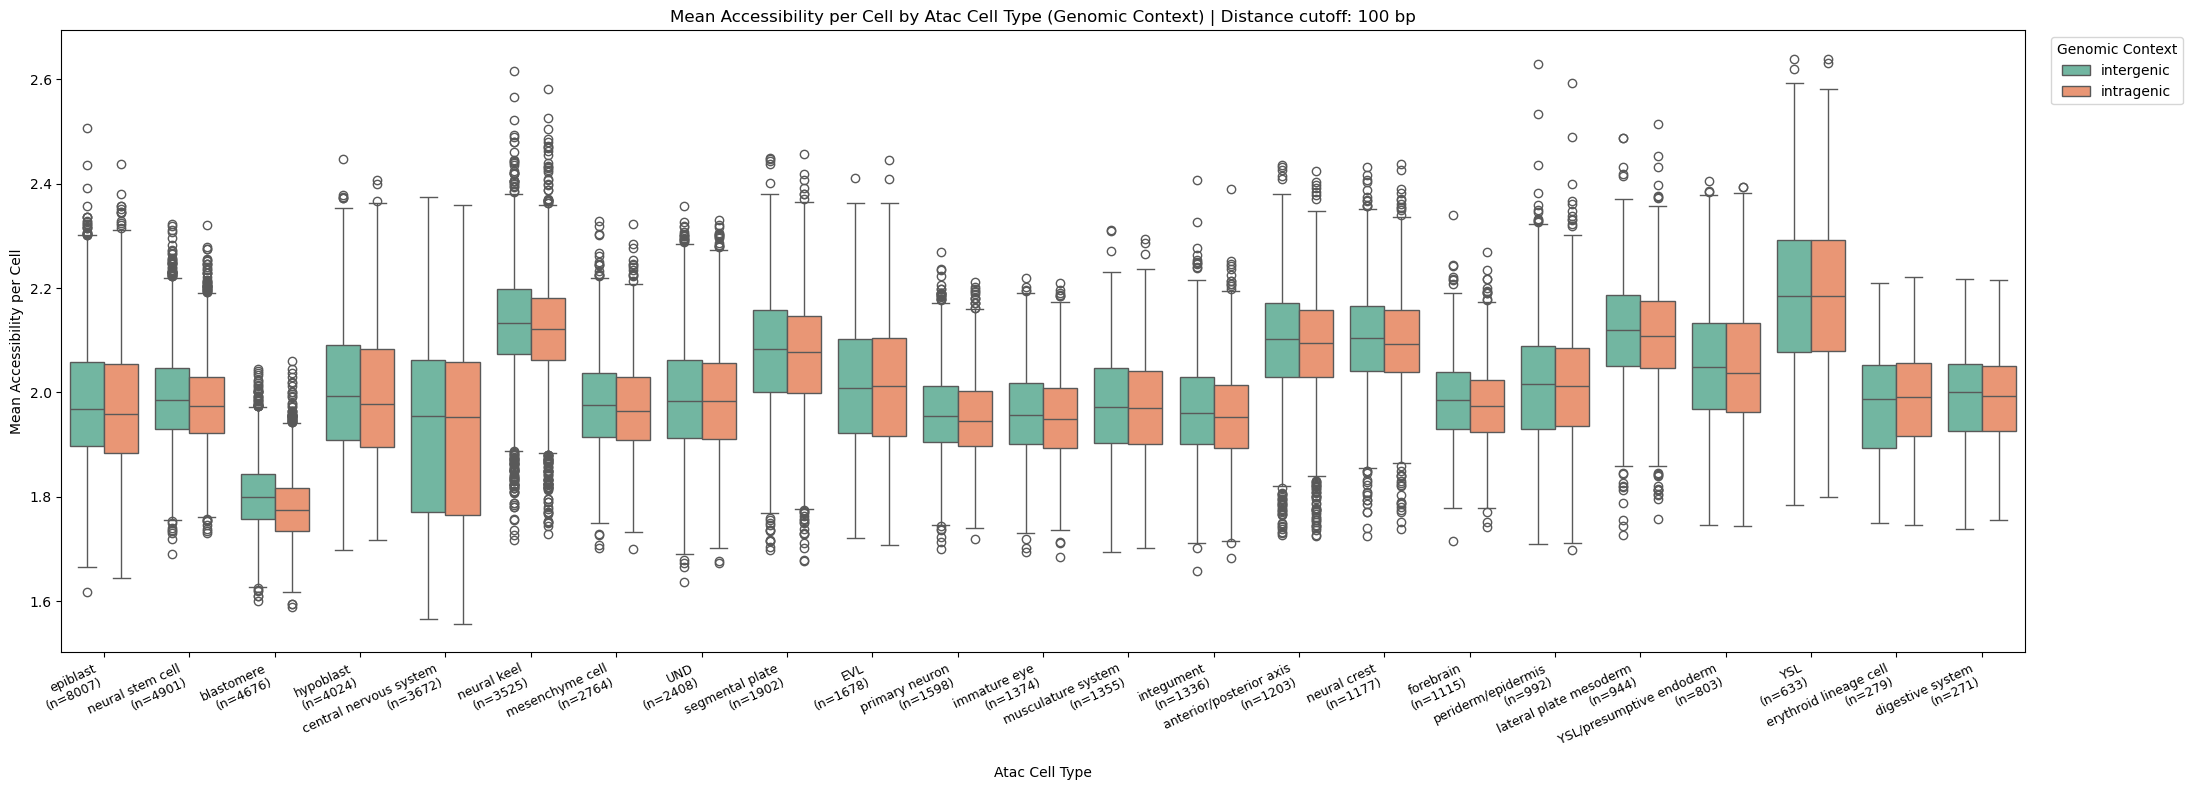

In [40]:


plot_summary_accessibility(
    summary_100, 
    gen_info="genomic_context",
    group_by="atac_cell_type",
    dist=100,
    show=True,
    save_path="../../data/embryo/plots/boxplot_mean_accessibility_per_celltype_regiontype_100bp.png"
)


####  distance from TSS = 10kb 
- Differences ebetween enhance/promoters are smoothened but again there is no pseudobulk or cell type that seems to behave differently than the others 

In [ ]:
ann_10kb = annotate_peaks_with_genomic_info(log_seq, gene_info, distance_threshold=10_000)
summary_10kb = summarize_peak_accessibility(atac_data_df, ann_10kb, atac_metadata_df)
print(summary_10kb.head())

/tmp/ipykernel_1803020/4288730143.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=25, ha='right', fontsize=9)


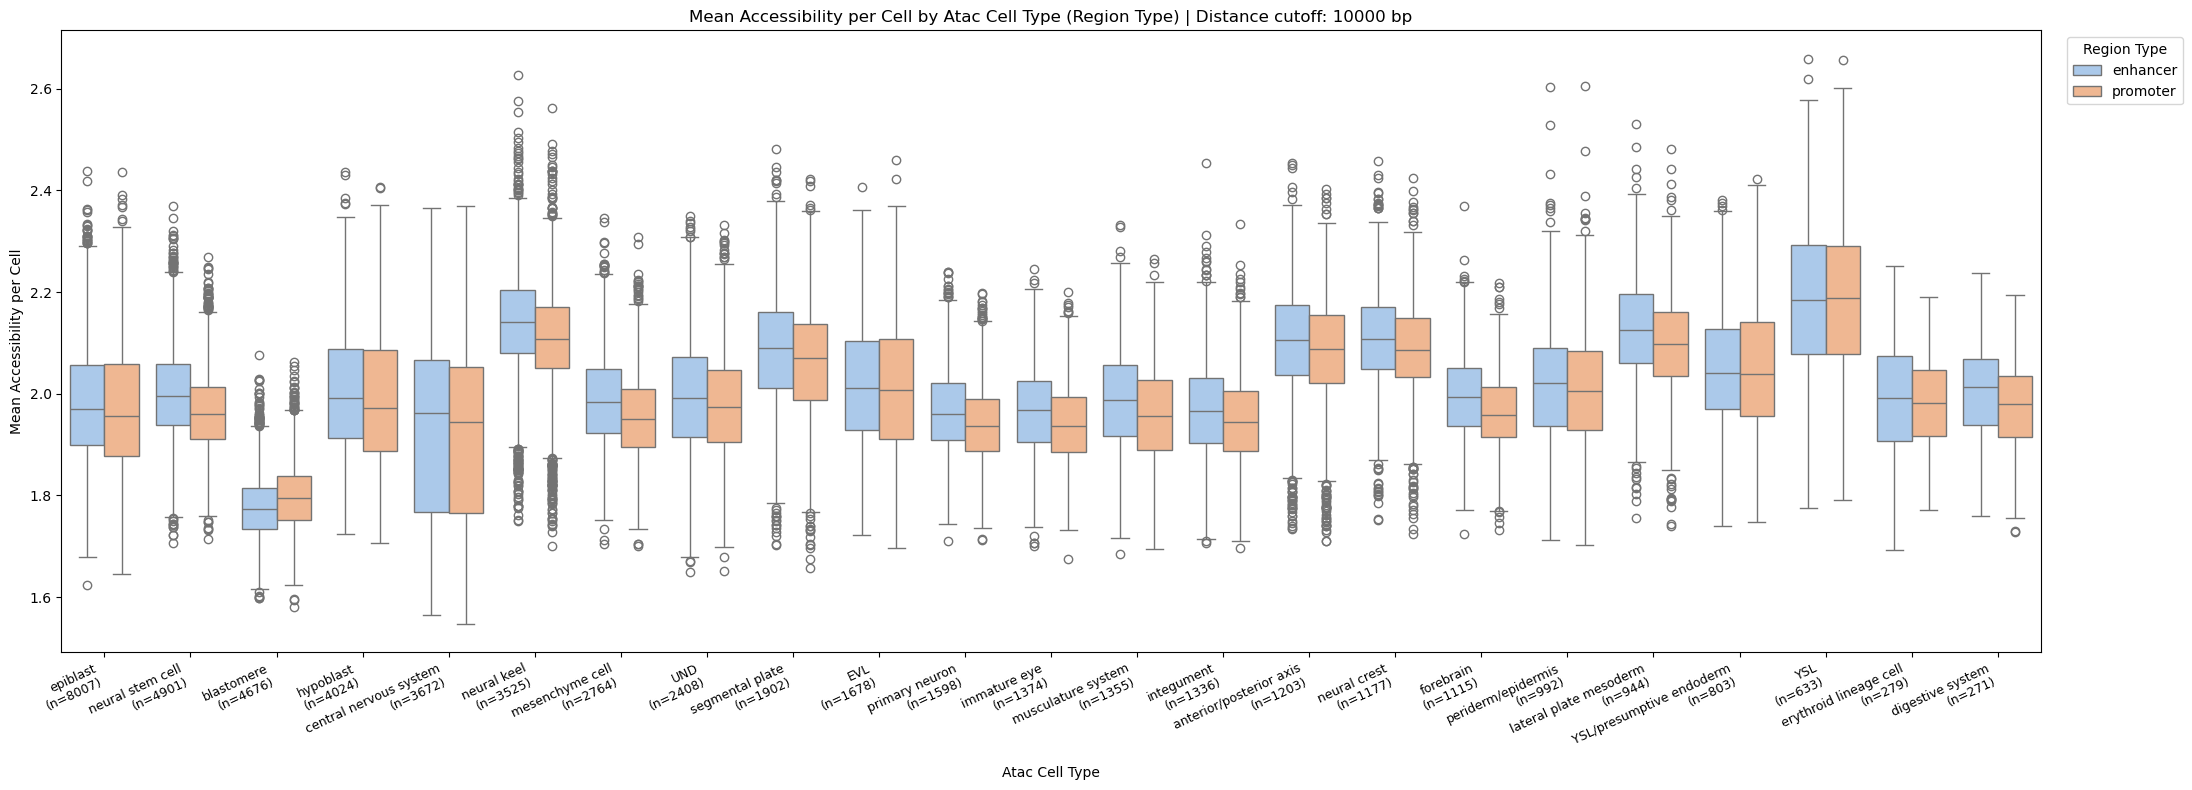

In [41]:


plot_summary_accessibility(
    summary_10kb, 
    gen_info="region_type",
    group_by="atac_cell_type",
    dist=10_000,
    show=True,
    save_path="../../data/embryo/plots/boxplot_mean_accessibility_per_celltype_regiontype_100bp.png"
)


In [1]:


plot_summary_accessibility(
    summary_10kb, 
    gen_info="genomic_context",
    group_by="atac_cell_type",
    dist=10_000,
    show=True,
    save_path="../../data/embryo/plots/boxplot_mean_accessibility_per_celltype_regiontype_10kb.png"
)


NameError: name 'plot_summary_accessibility' is not defined